In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import paired_cosine_distances
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
BASE_PATH = Path('../')
DATA_PATH = BASE_PATH / 'data'
TRAIN_DIR = DATA_PATH / 'train'
TEST_DIR = DATA_PATH / 'test'
TRAIN_CSV = DATA_PATH / 'train.csv'

# Load train data
print("Loading training data...")
train_df = pd.read_csv(TRAIN_CSV)

def get_text(file_path):
    """Reads text from a file"""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return f.read()
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return ""

# Load text content into df
tqdm.pandas(desc="Loading Text 1")
train_df['text_1'] = train_df['id'].progress_apply(lambda x: get_text(TRAIN_DIR / f'article_{x:04d}' / 'file_1.txt'))

tqdm.pandas(desc="Loading Text 2")
train_df['text_2'] = train_df['id'].progress_apply(lambda x: get_text(TRAIN_DIR / f'article_{x:04d}' / 'file_2.txt'))

# Create cols for real and fake text
train_df['real_text'] = np.where(train_df['real_text_id'] == 1, train_df['text_1'], train_df['text_2'])
train_df['fake_text'] = np.where(train_df['real_text_id'] == 1, train_df['text_2'], train_df['text_1'])

print("Data Loading complete")
print(f"Train DataFrame shape: {train_df.shape}")
display(train_df.head())

Loading training data...


Loading Text 1:   0%|          | 0/95 [00:00<?, ?it/s]

Loading Text 2:   0%|          | 0/95 [00:00<?, ?it/s]

Data Loading complete
Train DataFrame shape: (95, 6)


,id,real_text_id,text_1,text_2,real_text,fake_text
0,0,1,The VIRSA (Visible Infrared Survey Telescope A...,The China relay network has released a signifi...,The VIRSA (Visible Infrared Survey Telescope A...,The China relay network has released a signifi...
1,1,2,China\nThe goal of this project involves achie...,The project aims to achieve an accuracy level ...,The project aims to achieve an accuracy level ...,China\nThe goal of this project involves achie...
2,2,1,Scientists can learn about how galaxies form a...,Dinosaur eggshells offer clues about what dino...,Scientists can learn about how galaxies form a...,Dinosaur eggshells offer clues about what dino...
3,3,2,China\nThe study suggests that multiple star s...,The importance for understanding how stars evo...,The importance for understanding how stars evo...,China\nThe study suggests that multiple star s...
4,4,2,Dinosaur Rex was excited about his new toy set...,Analyzing how fast stars rotate within a galax...,Analyzing how fast stars rotate within a galax...,Dinosaur Rex was excited about his new toy set...


In [3]:
import textstat
from collections import Counter
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

def create_features(text):
    """Extracts a dictionary of features from a single text"""
    if not isinstance(text, str) or not text:
        return {
            'char_len': 0, 'word_count': 0, 'sent_count': 0,
            'avg_word_len': 0, 'avg_sent_len': 0, 'stopword_ratio': 0,
            'punct_count': 0, 'flesch_score': 0, 'unique_word_ratio': 0
        }
    words = text.split()
    word_count = len(words)
    char_len = len(text)

    if word_count == 0:
        return {
            'char_len': char_len, 'word_count': 0, 'sent_count': 0,
            'avg_word_len': 0, 'avg_sent_len': 0, 'stopword_ratio': 0, 'punct_count': 0, 'flesch_score': 206.835, 'unique_word_ratio': 0
        }
    
    sent_count = textstat.sentence_count(text)

    avg_word_len = sum(len(word) for word in words) / word_count
    avg_sent_len = word_count / sent_count if sent_count > 0 else 0

    stopwords_in_text = [word for word in words if word.lower() in stop_words]
    stopword_ratio = len(stopwords_in_text) / word_count

    punct_count = len(re.findall(r'[!?,.;:\-\(\)\[\]"\']', text))

    unique_word_ratio = len(set(w.lower() for w in words)) / word_count

    # Readability Scores
    flesch_score = textstat.flesch_reading_ease(text)

    features = {
        'char_len': char_len,
        'word_count': word_count,
        'sent_count': sent_count,
        'avg_word_len': avg_word_len,
        'avg_sent_len': avg_sent_len,
        'stopword_ratio': stopword_ratio,
        'punct_count': punct_count,
        'flesch_score': flesch_score,
        'unique_word_ratio': unique_word_ratio,
    }
    return features

print("Creating features for text_1 and text_2...")

# Apply to text_1
feats_1 = train_df['text_1'].progress_apply(create_features)
feats_1_df = pd.json_normalize(feats_1)
feats_1_df.columns = [f'{col}_1' for col in feats_1_df.columns]

# Apply to text_2
feats_2 = train_df['text_2'].progress_apply(create_features)
feats_2_df = pd.json_normalize(feats_2)
feats_2_df.columns = [f'{col}_2' for col in feats_2_df.columns]

# Concatenate features
feature_df = pd.concat([feats_1_df, feats_2_df], axis=1)

# Create Pairwise (Difference and Ratio) Features
print("Creating pairwise features...")
base_features = [col.replace('_1', '') for col in feats_1_df.columns]
for col in base_features:
    epsilon = 1e-6
    feature_df[f'{col}_diff'] = feature_df[f'{col}_1'] - feature_df[f'{col}_2']
    feature_df[f'{col}_ratio'] = feature_df[f'{col}_1'] / (feature_df[f'{col}_2'] + epsilon)

print("Feature engineering complete.")
display(feature_df.head())


Creating features for text_1 and text_2...


Loading Text 2:   0%|          | 0/95 [00:00<?, ?it/s]

Loading Text 2:   0%|          | 0/95 [00:00<?, ?it/s]

Creating pairwise features...
Feature engineering complete.


,char_len_1,word_count_1,sent_count_1,avg_word_len_1,avg_sent_len_1,stopword_ratio_1,punct_count_1,flesch_score_1,unique_word_ratio_1,char_len_2,...,avg_sent_len_diff,avg_sent_len_ratio,stopword_ratio_diff,stopword_ratio_ratio,punct_count_diff,punct_count_ratio,flesch_score_diff,flesch_score_ratio,unique_word_ratio_diff,unique_word_ratio_ratio
0,2196,304,9,6.226974,33.777778,0.194079,32,-4.937217,0.802632,2018,...,4.177778,1.141141,-0.076191,0.718089,-1,0.969697,-21.858967,-0.291767,0.005334,1.006689
1,3124,454,9,5.883260,50.444444,0.321586,47,-3.233476,0.698238,936,...,27.611111,2.209246,0.058812,1.223808,24,2.043478,-23.044309,-0.163218,-0.155777,0.817594
2,1139,159,4,6.169811,39.750000,0.289308,16,0.219231,0.823899,801,...,-1.916667,0.954000,-0.030692,0.904085,7,1.777778,-17.976952,0.012048,-0.048101,0.944838
3,1774,263,8,5.749049,32.875000,0.326996,52,23.320625,0.726236,1869,...,-4.553571,0.878340,0.056004,1.206658,35,3.058823,24.651213,-17.526566,0.031579,1.045459
4,195,34,3,4.764706,11.333333,0.500000,6,68.431667,0.882353,871,...,-19.416667,0.368564,0.256098,2.049992,-13,0.315789,57.016667,5.994889,0.036824,1.043551


--- Fold 1/5 ---
[0]	validation_0-error:0.52632
[100]	validation_0-error:0.47368
[102]	validation_0-error:0.47368
Fold 1 Pairwise Accuracy: 0.57895
--- Fold 2/5 ---
[0]	validation_0-error:0.26316
[100]	validation_0-error:0.15789
[106]	validation_0-error:0.15789
Fold 2 Pairwise Accuracy: 0.89474
--- Fold 3/5 ---
[0]	validation_0-error:0.21053
[100]	validation_0-error:0.10526
[108]	validation_0-error:0.10526
Fold 3 Pairwise Accuracy: 0.89474
--- Fold 4/5 ---
[0]	validation_0-error:0.10526
[100]	validation_0-error:0.15789
Fold 4 Pairwise Accuracy: 0.89474
--- Fold 5/5 ---
[0]	validation_0-error:0.36842
[100]	validation_0-error:0.15789
[107]	validation_0-error:0.15789
Fold 5 Pairwise Accuracy: 0.89474

Overall CV Pairwise Accuracy: 0.83158


c:\Users\bharg\miniconda3\Lib\site-packages\seaborn\categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)


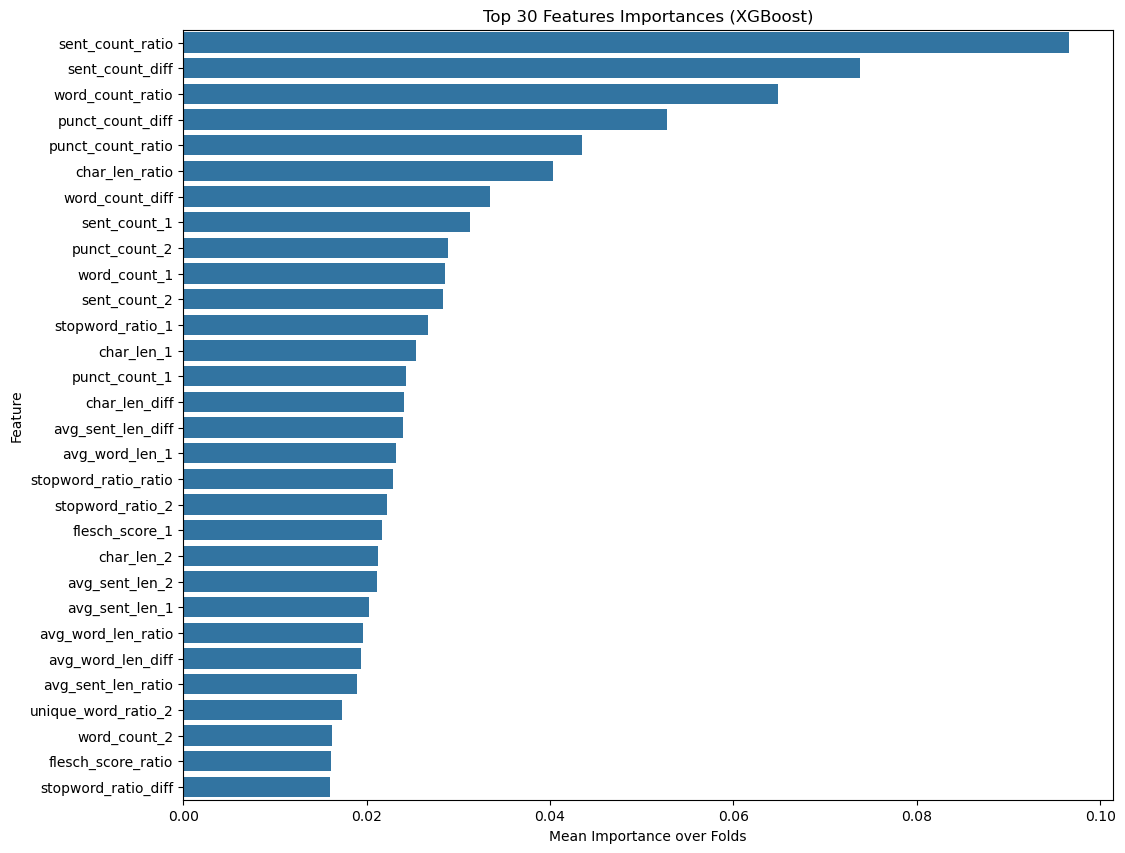

In [4]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Target
y = train_df['real_text_id'] - 1
X = feature_df.copy()

N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X))
models = []
feature_importances = pd.DataFrame(index=X.columns)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"--- Fold {fold+1}/{N_SPLITS} ---")

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    model = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        n_estimators=5000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.7,
        colsample_bytree=0.7,
        tree_method='hist',     
        eval_metric='error',
        early_stopping_rounds=100,  
        verbosity=0
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=100
    )

    preds = model.predict(X_val)
    oof_preds[val_idx] = preds
    models.append(model)
    feature_importances[f'fold_{fold+1}'] = model.feature_importances_

    # Evaluate fold
    acc = accuracy_score(y_val, preds)
    print(f"Fold {fold+1} Pairwise Accuracy: {acc:.5f}")

# Overall CV score
overall_accuracy = accuracy_score(y, oof_preds)
print(f"\nOverall CV Pairwise Accuracy: {overall_accuracy:.5f}")

# Feature importance
feature_importances['mean'] = feature_importances.mean(axis=1)
feature_importances.sort_values('mean', ascending=False, inplace=True)

plt.figure(figsize=(12, 10))
sns.barplot(x='mean', y=feature_importances.index[:30], data=feature_importances.head(30))
plt.title('Top 30 Features Importances (XGBoost)')
plt.xlabel('Mean Importance over Folds')
plt.ylabel('Feature')
plt.show()

In [6]:
#Optuna
import optuna

def objective_xgb(trial):
    params = {
        'objective': 'binary:logistic',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'n_estimators': 5000,
        'tree_method': 'hist',          
        'verbosity': 0,                 
        'eval_metric': 'error',         
        'early_stopping_rounds': 100,   
        'random_state': 42              
    }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    accuracies = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False  
        )

        preds = model.predict(X_val)
        acc = accuracy_score(y_val, preds)
        accuracies.append(acc)

    return np.mean(accuracies)

# Run Optuna
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100)

trials_df = study_xgb.trials_dataframe()
top10_trials = trials_df.sort_values("value", ascending=False).head(10)

print("\nTop 10 trials:")
print(top10_trials[["number", "value", "params_learning_rate", "params_max_depth", 
                    "params_subsample", "params_colsample_bytree", "params_min_child_weight"]])


print("Best parameters (XGBoost):", study_xgb.best_params)
print("Best CV accuracy:", study_xgb.best_value)

[I 2025-08-24 00:41:56,213] A new study created in memory with name: no-name-1d2dc9ef-ed80-4fe6-a05a-ca3af28c52ff
[I 2025-08-24 00:41:56,326] Trial 0 finished with value: 0.5157930107526881 and parameters: {'learning_rate': 0.022477142032062917, 'max_depth': 13, 'subsample': 0.652334450744379, 'colsample_bytree': 0.6933366536563477, 'min_child_weight': 18}. Best is trial 0 with value: 0.5157930107526881.
[I 2025-08-24 00:41:56,433] Trial 1 finished with value: 0.5157930107526881 and parameters: {'learning_rate': 0.02849786995692108, 'max_depth': 8, 'subsample': 0.795498573809873, 'colsample_bytree': 0.6220009912370417, 'min_child_weight': 12}. Best is trial 0 with value: 0.5157930107526881.
[I 2025-08-24 00:41:56,543] Trial 2 finished with value: 0.5157930107526881 and parameters: {'learning_rate': 0.06954124029805508, 'max_depth': 8, 'subsample': 0.8085547847057147, 'colsample_bytree': 0.5500467167420328, 'min_child_weight': 14}. Best is trial 0 with value: 0.5157930107526881.
[I 2025


Top 10 trials:
    number     value  params_learning_rate  params_max_depth  \
60      60  0.863239              0.043465                15   
98      98  0.863239              0.050007                15   
96      96  0.862903              0.032029                15   
99      99  0.852823              0.052425                15   
97      97  0.852823              0.031671                15   
94      94  0.852823              0.031148                 6   
31      31  0.852823              0.053256                 4   
43      43  0.852823              0.026800                10   
61      61  0.852823              0.042558                15   
14      14  0.852487              0.042367                 4   

    params_subsample  params_colsample_bytree  params_min_child_weight  
60          0.650299                 0.821597                        1  
98          0.661169                 0.696862                        1  
96          0.695918                 0.718581               

In [9]:
# Configuration
ST_MODEL_NAME = 'sentence-transformers/all-mpnet-base-v2'

print("Loading Sentence Transformer model...")
st_model = SentenceTransformer(ST_MODEL_NAME)

print("Encoding texts...")
embeddings1 = st_model.encode(train_df['text_1'].tolist(), show_progress_bar=True)
embeddings2 = st_model.encode(train_df['text_2'].tolist(), show_progress_bar=True)

print(f"Embeddings created. Shape: {embeddings1.shape}")

print("Creating semantic features")

# 1. Cosine Similarity
cosine_similarities = 1 - paired_cosine_distances(embeddings1, embeddings2)

# 2. Element wise Differences
embedding_diffs = embeddings1 - embeddings2

# Combine two a new feature DataFrame
semantic_features_df = pd.DataFrame(embedding_diffs)
semantic_features_df.columns = [f'sem_diff_{i}' for i in range(embedding_diffs.shape[1])]
semantic_features_df['cosine_sim'] = cosine_similarities

print("Semantic Features Created")
display(semantic_features_df.head())

# Create the super feature set
X_super = pd.concat([feature_df, semantic_features_df], axis=1)
y = train_df['real_text_id'] - 1

print(f"Super feature set created. Shape: {X_super.shape}")

Loading Sentence Transformer model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\bharg\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\bharg\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding texts...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Embeddings created. Shape: (95, 768)
Creating semantic features
Semantic Features Created


,sem_diff_0,sem_diff_1,sem_diff_2,sem_diff_3,sem_diff_4,sem_diff_5,sem_diff_6,sem_diff_7,sem_diff_8,sem_diff_9,...,sem_diff_759,sem_diff_760,sem_diff_761,sem_diff_762,sem_diff_763,sem_diff_764,sem_diff_765,sem_diff_766,sem_diff_767,cosine_sim
0,0.019083,0.006649,0.014612,-0.021872,0.013211,0.006887,0.016760,-0.006569,0.021447,0.004465,...,0.033263,0.005071,-0.003286,-0.022461,-0.016347,0.011188,0.021890,0.042394,0.019980,0.551330
1,-0.002131,0.100618,-0.006860,-0.015465,-0.002975,-0.005482,0.043374,0.023411,-0.042388,0.009743,...,-0.008845,-0.001277,-0.013604,0.014051,-0.015411,-0.013543,-0.029538,0.019512,-0.032364,0.610046
2,-0.073394,-0.059585,0.028701,-0.039264,0.008226,0.002810,-0.004064,0.037426,0.115684,0.022992,...,0.032491,-0.043163,0.059642,-0.021499,-0.070247,0.023989,-0.014840,-0.031483,-0.030843,0.247873
3,0.074293,0.040511,-0.004778,-0.016028,0.043253,-0.019031,0.010677,-0.001667,-0.018004,-0.009036,...,-0.051690,-0.010257,0.004975,0.017619,0.041261,-0.029366,-0.006718,-0.010197,-0.063887,0.570451
4,0.098058,0.052397,-0.012488,0.083774,0.019192,0.008235,-0.029036,-0.039514,-0.045138,0.004903,...,0.043760,-0.012135,0.006492,0.002710,0.046947,0.009172,0.004975,0.035460,-0.000592,0.048204


Super feature set created. Shape: (95, 805)


In [ ]:
best_xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.04346,
    'max_depth': 15,
    'subsample': 0.65029,
    'colsample_bytree': 0.8286,
    'min_child_weight': 1,
    'random_state': 42,
    'n_jobs': -1,
    'early_stopping_rounds': 100  
}

N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

oof_preds_super = np.zeros(len(X_super))
models_super = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_super, y)):
    print(f"--- Fold {fold+1}/{N_SPLITS} ---")
    
    X_train, y_train = X_super.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X_super.iloc[val_idx], y.iloc[val_idx]
    
    model = xgb.XGBClassifier(
        n_estimators=1000,
        **best_xgb_params
    )
    
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False)
    
    preds = model.predict(X_val)
    oof_preds_super[val_idx] = preds
    models_super.append(model)
    
    acc = accuracy_score(y_val, preds)
    print(f"Fold {fold+1} Pairwise Accuracy: {acc:.5f}")

overall_accuracy_super = accuracy_score(y, oof_preds_super)
print(f"\nOverall CV Pairwise Accuracy with SUPER Features: {overall_accuracy_super:.5f}")

--- Fold 1/5 ---
Fold 1 Pairwise Accuracy: 0.78947
--- Fold 2/5 ---
Fold 2 Pairwise Accuracy: 0.89474
--- Fold 3/5 ---
Fold 3 Pairwise Accuracy: 1.00000
--- Fold 4/5 ---
Fold 4 Pairwise Accuracy: 1.00000
--- Fold 5/5 ---
Fold 5 Pairwise Accuracy: 0.94737

Overall CV Pairwise Accuracy with SUPER Features: 0.92632


In [ ]:
print("Training on final XGBoost model on the entire training dataset...")

best_xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.04346,
    'max_depth': 15,
    'subsample': 0.65029,
    'colsample_bytree': 0.8286,
    'min_child_weight': 1,
    'random_state': 42,
    'n_jobs': -1,
}
final_model = xgb.XGBClassifier(**best_xgb_params)
final_model.fit(X_super, y)

print("Final model training complete.")


Training on final XGBoost model on the entire training dataset...
Final model training complete.


In [ ]:
# Create Inference Pipeline for test data

print("Loading test data...")
import re

def extract_id_from_dirname(dirname):
    """Extract numeric ID from directory names like 'article_0000' or '1501'"""
    match = re.search(r'(\d+)', dirname)
    if match:
        return int(match.group(1))
    else:
        try:
            return int(dirname)
        except ValueError:
            return None

test_dirs = [d for d in TEST_DIR.iterdir() if d.is_dir()]
test_ids_with_names = []

for d in test_dirs:
    numeric_id = extract_id_from_dirname(d.name)
    if numeric_id is not None:
        test_ids_with_names.append((numeric_id, d.name))

# Sort by numeric ID
test_ids_with_names.sort(key=lambda x: x[0])
test_ids = [x[0] for x in test_ids_with_names]
test_dir_names = [x[1] for x in test_ids_with_names]

print(f"Found {len(test_ids)} test directories")
print(f"ID range: {min(test_ids)} to {max(test_ids)}")
print(f"Sample directory names: {test_dir_names[:5]}")

test_df = pd.DataFrame({
    'id': test_ids, 
    'dir_name': test_dir_names
})

# Modified get_text function calls to use directory names
def get_text_by_dir_name(dir_name, filename):
    """Get text using the actual directory name"""
    return get_text(TEST_DIR / dir_name / filename)

tqdm.pandas(desc="Loading Test Text 1")
test_df['text_1'] = test_df['dir_name'].progress_apply(lambda x: get_text_by_dir_name(x, 'file_1.txt'))

tqdm.pandas(desc="Loading Test Text 2") 
test_df['text_2'] = test_df['dir_name'].progress_apply(lambda x: get_text_by_dir_name(x, 'file_2.txt'))

print(f"Test data loaded. Shape: {test_df.shape}")

# Apply the Full Feature Engineering Pipeline to the Test Data

# 1. Structural/Lexical Features (using the function from Phase 2)
print("Creating structural features for test set...")
test_feats_1 = test_df['text_1'].progress_apply(create_features)
test_feats_1_df = pd.json_normalize(test_feats_1)
test_feats_1_df.columns = [f'{col}_1' for col in test_feats_1_df.columns]

test_feats_2 = test_df['text_2'].progress_apply(create_features)
test_feats_2_df = pd.json_normalize(test_feats_2)
test_feats_2_df.columns = [f'{col}_2' for col in test_feats_2_df.columns]

test_feature_df = pd.concat([test_feats_1_df, test_feats_2_df], axis=1)
base_features = [col.replace('_1', '') for col in test_feats_1_df.columns]

for col in base_features:
    epsilon = 1e-6
    test_feature_df[f'{col}_diff'] = test_feature_df[f'{col}_1'] - test_feature_df[f'{col}_2']
    test_feature_df[f'{col}_ratio'] = test_feature_df[f'{col}_1'] / (test_feature_df[f'{col}_2'] + epsilon)

# Semantic Features
print("Creating semantic features for test set...")
st_model = SentenceTransformer(ST_MODEL_NAME)  # Reload model if needed

test_embeddings1 = st_model.encode(test_df['text_1'].tolist(), show_progress_bar=True)
test_embeddings2 = st_model.encode(test_df['text_2'].tolist(), show_progress_bar=True)

test_cosine_similarities = 1 - paired_cosine_distances(test_embeddings1, test_embeddings2)
test_embedding_diffs = test_embeddings1 - test_embeddings2

test_semantic_features_df = pd.DataFrame(test_embedding_diffs)
test_semantic_features_df.columns = [f'sem_diff_{i}' for i in range(test_embedding_diffs.shape[1])]
test_semantic_features_df['cosine_sim'] = test_cosine_similarities

# Combine into the final "Super" test feature set
print("Combining features for the final test set...")
X_test_super = pd.concat([test_feature_df, test_semantic_features_df], axis=1)

# Ensure the columns are in the same order as the training data
try:
    X_test_super = X_test_super[X_super.columns]
    print(f"Final test feature set created. Shape: {X_test_super.shape}")
except KeyError as e:
    print(f"Column mismatch error: {e}")
    print("Training columns not in test set:")
    missing_cols = set(X_super.columns) - set(X_test_super.columns)
    print(missing_cols)
    print("Test columns not in training set:")
    extra_cols = set(X_test_super.columns) - set(X_super.columns)
    print(extra_cols)
    
    # Use intersection of columns for now
    common_cols = list(set(X_super.columns).intersection(set(X_test_super.columns)))
    X_test_super = X_test_super[common_cols]
    print(f"Using common columns only. Final shape: {X_test_super.shape}")

print("Test feature engineering complete!")

Loading test data...
Found 1068 test directories
ID range: 0 to 1067
Sample directory names: ['article_0000', 'article_0001', 'article_0002', 'article_0003', 'article_0004']


Loading Test Text 1:   0%|          | 0/1068 [00:00<?, ?it/s]

Loading Test Text 2:   0%|          | 0/1068 [00:00<?, ?it/s]

Test data loaded. Shape: (1068, 4)
Creating structural features for test set...


Loading Test Text 2:   0%|          | 0/1068 [00:00<?, ?it/s]

Loading Test Text 2:   0%|          | 0/1068 [00:00<?, ?it/s]

Creating semantic features for test set...


Batches:   0%|          | 0/34 [00:00<?, ?it/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

Combining features for the final test set...
Final test feature set created. Shape: (1068, 805)
Test feature engineering complete!


In [18]:
print("Making predictions on the test set...")
test_predictions = final_model.predict(X_test_super)

# --- Create the submission file ---
submission_df = pd.DataFrame({'id': test_df['id']})

# The model predicts 0 (for text_1) or 1 (for text_2).
# The submission requires 1 or 2. So we add 1.
submission_df['real_text_id'] = test_predictions + 1

# Save to CSV
submission_path = BASE_PATH / 'submission.csv'
submission_df.to_csv(submission_path, index=False)

print(f"Submission file created successfully at: {submission_path}")
display(submission_df.head())


Making predictions on the test set...
Submission file created successfully at: ..\submission.csv


,id,real_text_id
0,0,2
1,1,2
2,2,1
3,3,1
4,4,2
